## 2-parameter function approximation

In [1]:
import math

import numpy as np
import pandas as pd

from scipy.optimize import fsolve, minimize, Bounds, LinearConstraint
from scipy.integrate import quad
from scipy import linspace, meshgrid, arange, empty, concatenate, newaxis, shape

import matplotlib.pyplot as plt

from collections import deque

import time

# from ipynb.fs.defs.P2_Q_values import *

In [2]:
###########################################################################################################################################################################################
# Model variables
global lam, theta_1, theta_2, s

# Total customers that we shall generate
global n
############################################################################################################################################################################################
def generate_arrival_process(x): # x is the arrival rate
    global interarrival_times
    global arrival_times
    
    interarrival_times = np.random.exponential(1/x, n)
    arrival_times = np.cumsum(interarrival_times)
###########################################################################################################################################################################################
def generate_service_times(x):
    global service_times
    global mean_service_time
    
    # Gamma distribution - mean = x[0]x[1] and variance = x[0]x[1]^2
    # mean_service_time = x[0]*x[1]
    # service_times = np.random.gamma(x[0], x[1], n)
    
    # Exponential distribution
    mean_service_time = 1/x
    service_times = np.random.exponential(1/x, n) 
###########################################################################################################################################################################################
class Customer(): # Creating an object "Customer" with relevant information
    price_paid = 0 # Price paid by customer
    arrival_time = 0 # Time of arrival
    departure_time = 0 # Time of departure
    service_time = 0 # Time taken for servicing
    waiting_time = 0 # Time spent waiting in queue (does not include service time)
    server = 0 # Server number which served the customer
    joining_decision = 0 # Does the customer join? 0 if yes, 1 if no
    number = 0 # Customer number (basically assigned between 0 and n-1)
    observed_system_occupancy = 0 # Observed number of customers in system upon arrival and before joining
    jump_virtual_waiting_time = 0 # Jump caused in virtual waiting time
###########################################################################################################################################################################################

In [3]:
def joining_probability(w, p):
    prob = np.exp(-theta_1*p - theta_2*w)
    return prob
    
def gradient_joining_probability(w, p):
    grad = np.exp(-theta_1*p - theta_2*w)*(-theta_1)
    return grad

def psi(w, a, p):
    psi = gradient_joining_probability(w, p)*(2*a-1)/((2*a-1)*joining_probability(w, p) + (1-a))
    return psi

def immediate_cost(a, p):
    cost = -lam*p*a
    return cost

def approx_Q(w, a, p, gamma_vec):
    G = 0
    G += gamma_vec[0] * gradient_joining_probability(w, p)*(2*a-1)/((2*a-1)*joining_probability(w, p) + (1-a))
    G += gamma_vec[1] * ((2*a-1)*joining_probability(w, p) + (1-a))*np.exp(-w)
    return G
    
def gradient_approx_Q(w, a, p):
    grad = np.zeros(2)
    grad[0] = gradient_joining_probability(w, p)*(2*a-1)/((2*a-1)*joining_probability(w, p) + (1-a))
    grad[1] = ((2*a-1)*joining_probability(w, p) + (1-a))*np.exp(-w)
    return grad




# Currently not being used
def estimator_gradient_revenue(w, a, p, gamma_vec):
    if a == 1:
        est = gradient_joining_probability(w, p) * approx_Q(w, 1, p, gamma_vec)/joining_probability(w, p)
    elif a == 0:
        est = -gradient_joining_probability(w, p) * approx_Q(w, 0, p, gamma_vec)/(1 - joining_probability(w, p))
        
    # est = gradient_joining_probability(w, p) * (approx_Q(w, 1, p, par_vec)/joining_probability(w, p) - approx_Q(w, 0, p, par_vec)/(1-joining_probability(w, p)))
    return est

In [4]:
def queue_simulation(initial_price, initial_gamma_vector):
    
# Idea

# Create array of workload of servers - Workload[s]
# Calculate min workload and server with min workload. If min workload > incoming customer patience, then customer balks. 
# Else, new workload (of min workload server) = current workload + service time of incoming customer
# This array will be updated during every arrival (only based on updated values we can decide balking or not!)
# If customer is non-balking, it is easy to get their waiting time in queue (= min workload amongst all servers)

# Maintain an array of "s" queues, each queue i literally represents queue in front of server i - append and pop customers during each arrival event
# Maintain a list to keep track of residual service times
    
    # Simulation variables
    global customers
    global server_workloads
    global dynamic_queues
    global dynamic_residual_service_times
    
    # Post processing variables
    global effective_arrival_times
    global effective_interarrival_times
    global departure_times
    global waiting_times # Waiting time array of only NB customers
    global all_waiting_times # Waiting times array of B+NB customers
    global upward_jump_virtual_waiting_times
    
    # RL variables
    global gamma_iterates
    global control_price_iterates
    global long_run_average_cost_iterates
    global eligibility_trace_iterates
    
##################################################################################################################################    
    # Initialization
    customers = [Customer() for i in range(n)]
    server_workloads = np.zeros(s)
    
    # New variables to keep track of
    dynamic_residual_service_times = np.zeros(s) # Keeps track of residual service times just after arrival events during the simulation
    dynamic_queues = [] # Maintains queues corresponding to all s servers
    for i in range(s):
        q = deque()
        dynamic_queues.append(q)

    # Relevant information to calculate and store
    effective_arrival_times = []
    effective_interarrival_times = []
    departure_times = []
    waiting_times = []
    upward_jump_virtual_waiting_times = []
    
    all_waiting_times = []
    
    # Storing relevant information
    gamma = initial_gamma_vector
    gamma_iterates = [gamma]
    
    control_price = initial_price
    control_price_iterates = [control_price]
    
    long_run_average_cost = 0
    long_run_average_cost_iterates = [long_run_average_cost]
    
    eligibility_trace = np.zeros(2)
    eligibility_trace_iterates = [eligibility_trace]
    alpha = 0
    
##################################################################################################################################   
    iterate = 1
    
    i = 0
    for cust in customers:
        
        # Storing customer information
        cust.number = i
        cust.arrival_time = arrival_times[i]
        cust.service_time = service_times[i]
        
        # Calculates number in system observed by incoming arrival
        system_size_at_joining_instant = sum(len(dynamic_queues[j]) for j in range(s))
        cust.observed_system_occupancy = system_size_at_joining_instant
        
        # Joining decision
        min_workload_server = server_workloads.argmin()
        cust.waiting_time = server_workloads[min_workload_server]
        joining_prob = joining_probability(cust.waiting_time, control_price)
        cust.joining_decision = np.random.binomial(1, joining_prob)
        
        all_waiting_times.append(cust.waiting_time)
        
        #################################################################################################################################
        # Parameter update
        
        actor_timescale = 0.99
        critic_timescale = 0.999
        
        # Simulating look ahead variables
        look_ahead_interarrival_time = np.random.exponential(1/lam)
        look_ahead_waiting_time = max(0, cust.waiting_time + cust.service_time*cust.joining_decision - look_ahead_interarrival_time)
        look_ahead_joining_probability = min(1, np.exp(-theta_1*control_price - theta_2*look_ahead_waiting_time))
        look_ahead_joining_decision = np.random.binomial(1, look_ahead_joining_probability)
        
        # Long run average revenue update
        long_run_average_cost = (1-1/np.power(iterate, actor_timescale))*long_run_average_cost + (1/np.power(iterate, actor_timescale))*immediate_cost(cust.joining_decision, control_price)
        long_run_average_cost_iterates.append(long_run_average_cost)
        
        # Bellman gap evaluation (Used for gamma update)
        bellman_gap = immediate_cost(cust.joining_decision, control_price) - long_run_average_cost + approx_Q(look_ahead_waiting_time, look_ahead_joining_decision, control_price, gamma) - approx_Q(cust.waiting_time, cust.joining_decision, control_price, gamma) 
        
        # Eligibility trace update (Used for gamma update)
        eligibility_trace = alpha*eligibility_trace + gradient_approx_Q(look_ahead_waiting_time, look_ahead_joining_decision, control_price)
        
        # Critic gamma parameter update
        gamma = gamma + (1/np.power(iterate, actor_timescale))*bellman_gap*eligibility_trace
        gamma_iterates.append(gamma)
        
        # Actor price parameter update
        # updated_control_price = control_price + (1/np.power(iterate, 0.999))*estimator_gradient_revenue(cust.waiting_time, cust.joining_decision, control_price, gamma)
        control_price = control_price - (1/np.power(iterate, critic_timescale))*approx_Q(look_ahead_waiting_time, look_ahead_joining_decision, control_price, gamma)*psi(look_ahead_waiting_time, look_ahead_joining_decision, control_price)
        control_price = max(0.01, control_price)
        control_price_iterates.append(control_price)

        iterate += 1
        #################################################################################################################################
        
        if cust.joining_decision == 1:
            cust.price_paid = control_price
            
            dynamic_queues[min_workload_server].append(i) # Customer joins queue corresponding to minimum workload server
            if len(dynamic_queues[min_workload_server]) == 1:
                dynamic_residual_service_times[min_workload_server] = cust.service_time

            effective_arrival_times.append(cust.arrival_time)

            cust.server = min_workload_server
            cust.departure_time = cust.arrival_time + cust.waiting_time + cust.service_time
            
            # Jump in virtual waiting time calculation
            cust.jump_virtual_waiting_time -= server_workloads[min_workload_server] # Subtracting virtual waiting time BEFORE customer arrival
            server_workloads[min_workload_server] += cust.service_time # Adds arriving customer's service time to minimum workload server
            min_workload_server = server_workloads.argmin() # Calculates new "minimum workload server"
            cust.jump_virtual_waiting_time += server_workloads[min_workload_server] # Adding new virtual waiting time AFTER customer arrival

            waiting_times.append(cust.waiting_time)
            departure_times.append(cust.departure_time)
            upward_jump_virtual_waiting_times.append(cust.jump_virtual_waiting_time)
        
            
        if i != n-1:
            # Time to update residual service times here. Mathematical formulation of the code is as follows:-
            # Suppose service times of a queue corresponding to a server are: 5(residual service time of customer being served),20,22,17,23,28,... and time since last arrival is 50,
            # Then, new queue becomes 14,23,28,... 
            for j in range(s):
                if len(dynamic_queues[j]) == 0:
                    dynamic_residual_service_times[j] = 0
                    continue

                time_until_next_arrival = arrival_times[i+1] - arrival_times[i]

                if time_until_next_arrival > dynamic_residual_service_times[j]:
                    time_until_next_arrival -= dynamic_residual_service_times[j]
                    dynamic_residual_service_times[j] = 0
                    dynamic_queues[j].popleft()
                else:
                    dynamic_residual_service_times[j] -= time_until_next_arrival
                    continue

                while len(dynamic_queues[j])!=0 and time_until_next_arrival > customers[dynamic_queues[j][0]].service_time:
                    time_until_next_arrival -= customers[dynamic_queues[j][0]].service_time
                    dynamic_queues[j].popleft()

                if len(dynamic_queues[j]) == 0:
                    dynamic_residual_service_times[j] = 0
                    continue
                else:
                    dynamic_residual_service_times[j] = customers[dynamic_queues[j][0]].service_time - time_until_next_arrival
            
            
            server_workloads -= (arrival_times[i+1] - arrival_times[i]) # Subtracting time passed until next arrival from all server workloads
            server_workloads = np.where(server_workloads < 0, 0, server_workloads)  # All those with workload < 0 are converted to 0
        
        i += 1
        
##################################################################################################################################
    # Post processing
    
    effective_arrival_times = np.array(effective_arrival_times)
    effective_interarrival_times = [effective_arrival_times[0]] + [j-i for i,j in zip(effective_arrival_times, effective_arrival_times[1:])]
    effective_interarrival_times = np.array(effective_interarrival_times)
    departure_times.sort()
    departure_times = np.array(departure_times)
    waiting_times = np.array(waiting_times)
    upward_jump_virtual_waiting_times = np.array(upward_jump_virtual_waiting_times)
    
    all_waiting_times = np.array(all_waiting_times)

## Simulation

In [12]:
lam = 20
theta_1 = 0.1
theta_2 = 0.2
s = 1

n = 1000000

generate_arrival_process(lam)
generate_service_times(1)

initial_control_price = 50
initial_gamma_vector = np.array([0, 0])

queue_simulation(initial_control_price, initial_gamma_vector)

Text(0.5, 1.0, 'Price iterates')

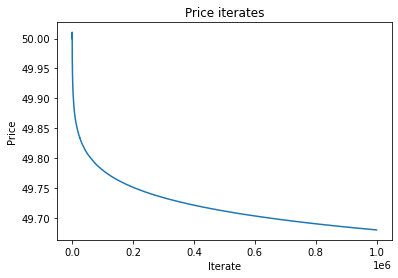

In [13]:
plt.plot(control_price_iterates)
plt.xlabel("Iterate")
plt.ylabel("Price")
plt.title("Price iterates")
# plt.savefig("Price iterates.pdf")

Text(0.5, 1.0, 'Gamma iterates')

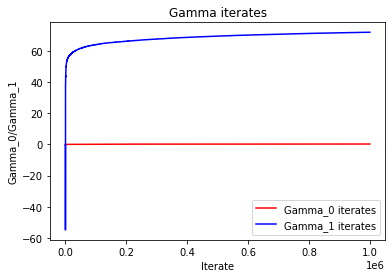

In [14]:
gamma_0_iterates = [gamma_iterates[i][0] for i in range(len(gamma_iterates))]
gamma_1_iterates = [gamma_iterates[i][1] for i in range(len(gamma_iterates))]


plt.plot(gamma_0_iterates, color="red", label="Gamma_0 iterates")
plt.plot(gamma_1_iterates, color="blue", label="Gamma_1 iterates")
plt.legend()
plt.xlabel("Iterate")
plt.ylabel("Gamma_0/Gamma_1")
plt.title("Gamma iterates")
# plt.savefig("Gamma iterates.pdf")

Text(0.5, 1.0, 'Function approximation for fixed price')

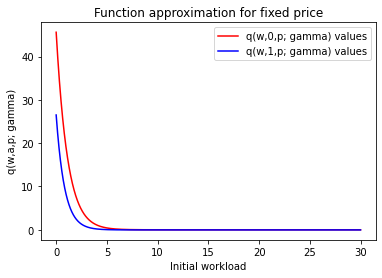

In [19]:
# output_gamma = gamma_iterates[-1]
output_gamma = gamma_iterates[-1]

init_workload = np.arange(0, 30, 0.01)

func_approx_Q_0 = []
func_approx_Q_1 = []

fixed_price = 10

for w in init_workload:
    temp_0 = approx_Q(w, 0, fixed_price, output_gamma)
    temp_1 = approx_Q(w, 1, fixed_price, output_gamma)
    func_approx_Q_0.append(temp_0)
    func_approx_Q_1.append(temp_1)

plt.plot(init_workload, func_approx_Q_0, color="red", label="q(w,0,p; gamma) values")
plt.plot(init_workload, func_approx_Q_1, color="blue", label="q(w,1,p; gamma) values")
plt.legend()
plt.xlabel("Initial workload")
plt.ylabel("q(w,a,p; gamma)")
plt.title("Function approximation for fixed price")

Text(0.5, 1.0, 'Long run average cost (Essentially estimates of -R(p))')

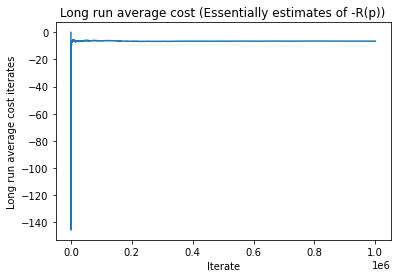

In [16]:
plt.plot(long_run_average_cost_iterates)
plt.xlabel("Iterate")
plt.ylabel("Long run average cost iterates")
plt.title("Long run average cost (Essentially estimates of -R(p))")

Text(0.5, 1.0, 'All customer waiting times')

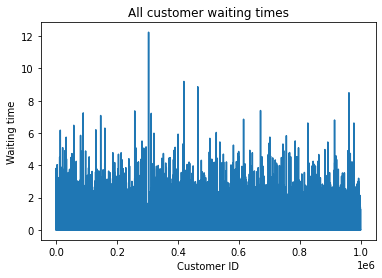

In [17]:
plt.plot(all_waiting_times)
plt.xlabel("Customer ID")
plt.ylabel("Waiting time")
plt.title("All customer waiting times")

In [18]:
fraction_balking_customers = 1 - len(effective_arrival_times)/n
print("Balking fraction = ", fraction_balking_customers)

effective_arrival_rate = (n*(1-fraction_balking_customers))/effective_arrival_times[-1]
print("Effective arrival rate = ", effective_arrival_rate)

Balking fraction =  0.993402
Effective arrival rate =  0.13204247669234145
